In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss)
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    original_loss = focal_loss(student_outputs[:,0,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            #loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), f"weights_KD_segformer_0514_Focal_Loss_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 0.8
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 7s 577ms/step - loss: 0.0198
Average validation loss: 0.1386439949274063
4/4 [==============================] - 7s 594ms/step - loss: 0.0198 - val_loss: 0.1386
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_80\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 10s 541ms/step - loss: 0.0154 - val_loss: 0.1386
Average validation loss: 0.1290145218372345
4/4 [==============================] - 10s 556ms/step - loss: 0.0154 - val_loss: 0.1338
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_80\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 12s 557ms/step - loss: 0.0116 - val_loss: 0.1338
Average validation loss: 0.1257217824459076
4/4 [==============================] - 12s 571ms/step - loss: 0.0116 - val_loss: 0.1311
Saved model weights to 'c:\Users\user\Desktop\天

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 738ms/step - loss: 6.9329e-04
Average validation loss: 0.12549855187535286
8/8 [==============================] - 6s 750ms/step - loss: 6.9329e-04 - val_loss: 0.1255
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_80\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 12s 723ms/step - loss: 6.7719e-04 - val_loss: 0.1255
Average validation loss: 0.0975976288318634
8/8 [==============================] - 12s 735ms/step - loss: 6.7719e-04 - val_loss: 0.1115
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_80\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 18s 729ms/step - loss: 6.7183e-04 - val_loss: 0.1115
Average validation loss: 0.11444810032844543
8/8 [==============================] - 18s 740ms/step - loss: 6.7183e-04 - val_loss: 0.1125
Epoch 4/10
8/8 [===

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 8s 694ms/step - loss: 0.0011
Average validation loss: 0.14386575917402902
12/12 [==============================] - 8s 708ms/step - loss: 0.0011 - val_loss: 0.1439
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_80\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 17s 719ms/step - loss: 9.6556e-04 - val_loss: 0.1439
Average validation loss: 0.12633608281612396
12/12 [==============================] - 17s 729ms/step - loss: 9.6556e-04 - val_loss: 0.1351
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_80\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 26s 700ms/step - loss: 9.3216e-04 - val_loss: 0.1351
Average validation loss: 0.10380154103040695
12/12 [==============================] - 26s 714ms/step - loss: 9.3216e-04 - val_loss: 0.1247
Saved model we

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 11s 692ms/step - loss: 6.3483e-04
Average validation loss: 0.06997639313340187
16/16 [==============================] - 11s 705ms/step - loss: 6.3483e-04 - val_loss: 0.0700
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_80\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 698ms/step - loss: 6.2982e-04 - val_loss: 0.0700
Average validation loss: 0.1099108699709177
16/16 [==============================] - 23s 708ms/step - loss: 6.2982e-04 - val_loss: 0.0899
Epoch 3/10
16/16 [==============================] - 34s 692ms/step - loss: 6.1446e-04 - val_loss: 0.0899
Average validation loss: 0.09221237525343895
16/16 [==============================] - 34s 706ms/step - loss: 6.1446e-04 - val_loss: 0.0907
Epoch 4/10
16/16 [==============================] - 45s 687ms/step - loss: 6.0643e-04 - val_loss: 0.0907
Average validation loss: 0.09963424131274223
16

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 708ms/step - loss: 4.7244e-04
Average validation loss: 0.10411590486764907
20/20 [==============================] - 14s 720ms/step - loss: 4.7244e-04 - val_loss: 0.1041
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_80\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 712ms/step - loss: 4.5926e-04 - val_loss: 0.1041
Average validation loss: 0.09990651905536652
20/20 [==============================] - 29s 724ms/step - loss: 4.5926e-04 - val_loss: 0.1020
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_80\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 43s 705ms/step - loss: 4.4756e-04 - val_loss: 0.1020
Average validation loss: 0.08758085370063781
20/20 [==============================] - 43s 716ms/step - loss: 4.4756e-04 - val_loss: 0.0972
Save

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 713ms/step - loss: 4.7448e-04
Average validation loss: 0.08851732934514682
24/24 [==============================] - 17s 725ms/step - loss: 4.7448e-04 - val_loss: 0.0885
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_80\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 720ms/step - loss: 4.4397e-04 - val_loss: 0.0885
Average validation loss: 0.0980947030087312
24/24 [==============================] - 35s 732ms/step - loss: 4.4397e-04 - val_loss: 0.0933
Epoch 3/10
24/24 [==============================] - 52s 714ms/step - loss: 4.2363e-04 - val_loss: 0.0933
Average validation loss: 0.10368224481741588
24/24 [==============================] - 52s 726ms/step - loss: 4.2363e-04 - val_loss: 0.0968
Epoch 4/10
24/24 [==============================] - 70s 709ms/step - loss: 4.0980e-04 - val_loss: 0.0968
Average validation loss: 0.09530573959151904
24

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 29s 726ms/step - loss: 5.8311e-04
Average validation loss: 0.08434729427099227
40/40 [==============================] - 30s 738ms/step - loss: 5.8311e-04 - val_loss: 0.0843
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_80\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 60s 749ms/step - loss: 5.2818e-04 - val_loss: 0.0843
Average validation loss: 0.10521317720413208
40/40 [==============================] - 60s 761ms/step - loss: 5.2818e-04 - val_loss: 0.0948
Epoch 3/10
40/40 [==============================] - 89s 716ms/step - loss: 4.9903e-04 - val_loss: 0.0948
Average validation loss: 0.09851069301366806
40/40 [==============================] - 89s 727ms/step - loss: 4.9903e-04 - val_loss: 0.0960
Epoch 4/10
40/40 [==============================] - 117s 707ms/step - loss: 4.7781e-04 - val_loss: 0.0960
Average validation loss: 0.10312794893980026


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 35s 723ms/step - loss: 4.8300e-04
Average validation loss: 0.0990756954997778
48/48 [==============================] - 35s 735ms/step - loss: 4.8300e-04 - val_loss: 0.0991
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_80\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 70s 718ms/step - loss: 4.3767e-04 - val_loss: 0.0991
Average validation loss: 0.09193745752175649
48/48 [==============================] - 70s 730ms/step - loss: 4.3767e-04 - val_loss: 0.0955
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_80\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 106s 730ms/step - loss: 3.9505e-04 - val_loss: 0.0955
Average validation loss: 0.1115793709953626
48/48 [==============================] - 106s 743ms/step - loss: 3.9505e-04 - val_loss: 0.1009
Epoc

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 41s 727ms/step - loss: 4.0375e-04
Average validation loss: 0.08237378405673164
56/56 [==============================] - 41s 738ms/step - loss: 4.0375e-04 - val_loss: 0.0824
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_80\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 81s 714ms/step - loss: 3.7312e-04 - val_loss: 0.0824
Average validation loss: 0.10277064942887851
56/56 [==============================] - 82s 725ms/step - loss: 3.7312e-04 - val_loss: 0.0926
Epoch 3/10
56/56 [==============================] - 122s 715ms/step - loss: 3.4066e-04 - val_loss: 0.0926
Average validation loss: 0.10955549563680377
56/56 [==============================] - 123s 726ms/step - loss: 3.4066e-04 - val_loss: 0.0982
Epoch 4/10
56/56 [==============================] - 163s 718ms/step - loss: 3.2451e-04 - val_loss: 0.0982
Average validation loss: 0.0926201923617294

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 46s 723ms/step - loss: 3.7345e-04
Average validation loss: 0.10719442600384355
64/64 [==============================] - 47s 735ms/step - loss: 3.7345e-04 - val_loss: 0.1072
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_80\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 93s 723ms/step - loss: 3.1596e-04 - val_loss: 0.1072
Average validation loss: 0.09975291742011905
64/64 [==============================] - 94s 735ms/step - loss: 3.1596e-04 - val_loss: 0.1035
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_80\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 140s 721ms/step - loss: 2.8331e-04 - val_loss: 0.1035
Average validation loss: 0.0969808273948729
64/64 [==============================] - 141s 733ms/step - loss: 2.8331e-04 - val_loss: 0.1013
Sav

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 51s 715ms/step - loss: 3.0458e-04
Average validation loss: 0.0961825086010827
72/72 [==============================] - 52s 727ms/step - loss: 3.0458e-04 - val_loss: 0.0962
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_80\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 104s 721ms/step - loss: 2.6013e-04 - val_loss: 0.0962
Average validation loss: 0.0953914945324262
72/72 [==============================] - 105s 732ms/step - loss: 2.6013e-04 - val_loss: 0.0958
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_80\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 157s 714ms/step - loss: 2.3119e-04 - val_loss: 0.0958
Average validation loss: 0.09612779774599606
72/72 [==============================] - 157s 726ms/step - loss: 2.3119e-04 - val_loss: 0.0959
Ep

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 58s 723ms/step - loss: 3.1143e-04
Average validation loss: 0.09793609976768494
80/80 [==============================] - 59s 735ms/step - loss: 3.1143e-04 - val_loss: 0.0979
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_80\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 116s 715ms/step - loss: 2.6833e-04 - val_loss: 0.0979
Average validation loss: 0.09295703545212745
80/80 [==============================] - 117s 727ms/step - loss: 2.6833e-04 - val_loss: 0.0954
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_80\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 174s 707ms/step - loss: 2.3636e-04 - val_loss: 0.0954
Average validation loss: 0.09687438495457172
80/80 [==============================] - 174s 718ms/step - loss: 2.3636e-04 - val_loss: 0.095

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 68s 712ms/step - loss: 3.9672e-04
Average validation loss: 0.09499523198852937
96/96 [==============================] - 70s 723ms/step - loss: 3.9672e-04 - val_loss: 0.0950
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_80\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 138s 708ms/step - loss: 3.3704e-04 - val_loss: 0.0950
Average validation loss: 0.09862412543346484
96/96 [==============================] - 139s 719ms/step - loss: 3.3704e-04 - val_loss: 0.0968
Epoch 3/10
96/96 [==============================] - 206s 704ms/step - loss: 2.9503e-04 - val_loss: 0.0968
Average validation loss: 0.09394033967206876
96/96 [==============================] - 207s 716ms/step - loss: 2.9503e-04 - val_loss: 0.0959
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_80\segformer_data_size_120.pth'

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 85s 706ms/step - loss: 3.2239e-04
Average validation loss: 0.08033457472920418
120/120 [==============================] - 86s 717ms/step - loss: 3.2239e-04 - val_loss: 0.0803
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_80\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 171s 706ms/step - loss: 2.9401e-04 - val_loss: 0.0803
Average validation loss: 0.09526079098383586
120/120 [==============================] - 172s 718ms/step - loss: 2.9401e-04 - val_loss: 0.0878
Epoch 3/10
120/120 [==============================] - 257s 706ms/step - loss: 2.6120e-04 - val_loss: 0.0878
Average validation loss: 0.09747347285350164
120/120 [==============================] - 258s 717ms/step - loss: 2.6120e-04 - val_loss: 0.0910
Epoch 4/10
120/120 [==============================] - 343s 704ms/step - loss: 2.3419e-04 - val_loss: 0.0910
Average validation loss: 0

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 103s 714ms/step - loss: 3.0574e-04
Average validation loss: 0.10529862571921614
144/144 [==============================] - 105s 726ms/step - loss: 3.0574e-04 - val_loss: 0.1053
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_80\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 208s 716ms/step - loss: 2.6631e-04 - val_loss: 0.1053
Average validation loss: 0.09244164617525207
144/144 [==============================] - 209s 727ms/step - loss: 2.6631e-04 - val_loss: 0.0989
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_80\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 313s 716ms/step - loss: 2.3786e-04 - val_loss: 0.0989
Average validation loss: 0.0932854941735665
144/144 [==============================] - 314s 727ms/step - loss: 2.3786e-04 - va

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 113s 705ms/step - loss: 2.2417e-04
Average validation loss: 0.09487445577979088
160/160 [==============================] - 115s 717ms/step - loss: 2.2417e-04 - val_loss: 0.0949
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_80\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 228s 706ms/step - loss: 2.0492e-04 - val_loss: 0.0949
Average validation loss: 0.09481956288218499
160/160 [==============================] - 230s 717ms/step - loss: 2.0492e-04 - val_loss: 0.0948
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_80\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 343s 708ms/step - loss: 1.8984e-04 - val_loss: 0.0948
Average validation loss: 0.09425910245627164
160/160 [==============================] - 345s 719ms/step - loss: 1.8984e-04 - v

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 143s 715ms/step - loss: 3.4589e-04
Average validation loss: 0.09711676858365535
200/200 [==============================] - 145s 727ms/step - loss: 3.4589e-04 - val_loss: 0.0971
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_80\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 286s 705ms/step - loss: 2.9828e-04 - val_loss: 0.0971
Average validation loss: 0.10121298924088479
200/200 [==============================] - 289s 716ms/step - loss: 2.9828e-04 - val_loss: 0.0992
Epoch 3/10
200/200 [==============================] - 429s 699ms/step - loss: 2.6984e-04 - val_loss: 0.0992
Average validation loss: 0.10037292942404746
200/200 [==============================] - 431s 710ms/step - loss: 2.6984e-04 - val_loss: 0.0996
Epoch 4/10
200/200 [==============================] - 571s 701ms/step - loss: 2.5059e-04 - val_loss: 0.0996
Average validation loss:

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 3:12 - loss: 1.8775e-04

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 173s 719ms/step - loss: 2.5243e-04
Average validation loss: 0.0997989721596241
240/240 [==============================] - 175s 731ms/step - loss: 2.5243e-04 - val_loss: 0.0998
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_80\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 345s 706ms/step - loss: 2.2749e-04 - val_loss: 0.0998
Average validation loss: 0.09640020305911699
240/240 [==============================] - 348s 717ms/step - loss: 2.2749e-04 - val_loss: 0.0981
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_80\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 517s 705ms/step - loss: 2.0867e-04 - val_loss: 0.0981
Average validation loss: 0.09753521320720514
240/240 [==============================] - 520s 717ms/step - loss: 2.0867e-04 - va

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.11905095711350441, 0.09921897914260626, 0.0955583892762661, 0.09392143961042165, 0.09754646757245064, 0.09761556369562943, 0.09863126699626447, 0.10193145914624134, 0.10246438476656165, 0.09922051972243935, 0.0984289626363251, 0.09774579483270644, 0.09634287084142368, 0.09747836813330649, 0.09682604663074018, 0.09864737354964018, 0.09593590345233678, 0.09520293294638395]
std_val_losses =  [0.059197058762894994, 0.04964945580354627, 0.024201889465567443, 0.010152331455596724, 0.007291012436824922, 0.0046222271831373365, 0.009777347977490362, 0.007017543583362396, 0.006850884827725684, 0.010019546238169325, 0.005038961307376449, 0.005529156555709315, 0.0051292307251091076, 0.004882108558648149, 0.0037013485582674623, 0.0034230003566144466, 0.00383086525971082, 0.003939473084740143]


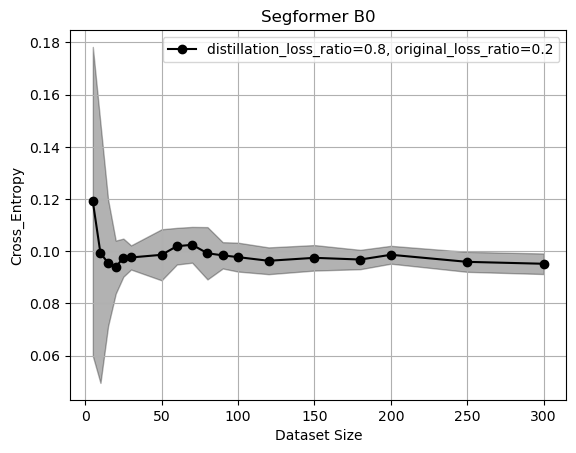

In [2]:
print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.show()